In [1]:
import numpy as np
import pandas as pd
#import geopandas as gp
import matplotlib.pyplot as plt
import folium
import json
from scipy.stats import pearsonr, spearmanr
import statsmodels.api as sm

In [2]:
nl_covid = pd.read_csv('../data/Raw/corona/nl_corona.csv',sep='\t')
tests = pd.read_csv('../data/Raw/external/covid-19_tests.csv',sep=';')
weather = pd.read_csv('../data/Raw/weather/weather.csv',sep='\t')
with open('../data/Raw/metadata/nl_metadata.json') as f:
    metadata = json.load(f)
nl_weather = weather['iso3166-2'].str[:2] == 'NL'
nl_weather_df = weather[nl_weather]
nl_weather_df
#missing data?
#print(nl_weather_df.isna().any().any())
nl_weather_df
reg_dict = {}
names = {}
for i in metadata['country_metadata']:
    reg_dict[int(i['covid_region_code'])] = [i['population']]
    names[int(i['covid_region_code'])] = i['iso3166-2_code']
    

reg_names = set(nl_covid['region_code'])
mask1 = nl_covid['confirmed_addition'].dropna()
mask_idk = nl_covid['confirmed_addition'].notnull()

#print(4344-sum(mask_idk))
for i in list(reg_names):
    mask = (nl_covid['region_code'] == i) & (nl_covid['confirmed_addition'].notnull())
    mask_covid=nl_covid[mask]
    reg_dict[i].append(sum(mask_covid['confirmed_addition']))
df1 = pd.DataFrame.from_dict(reg_dict)
df1 = df1.transpose()
final_df = df1.rename(names)
tests

,Version,Date_of_report,Date_of_statistics,Security_region_code,Security_region_name,Tested_with_result,Tested_positive
0,1,14/03/2021 09.00,01/06/2020,VR01,Groningen,2,0
1,1,14/03/2021 09.00,02/06/2020,VR01,Groningen,216,0
2,1,14/03/2021 09.00,03/06/2020,VR01,Groningen,204,0
3,1,14/03/2021 09.00,04/06/2020,VR01,Groningen,242,1
4,1,14/03/2021 09.00,05/06/2020,VR01,Groningen,222,0
...,...,...,...,...,...,...,...
7405,1,14/03/2021 09.00,08/03/2021,NaN,Onbekend,18,0
7406,1,14/03/2021 09.00,09/03/2021,NaN,Onbekend,22,0
7407,1,14/03/2021 09.00,10/03/2021,NaN,Onbekend,24,1
7408,1,14/03/2021 09.00,11/03/2021,NaN,Onbekend,25,1


In [3]:
new_names = {}
for i in set(nl_covid['region_name']):
    new_names[i] = []


In [67]:
new_names

{'Zeeland': [],
 'Flevoland': [],
 'Friesland': [],
 'Groningen': [],
 'Limburg': [],
 'Utrecht': [],
 'Noord-Holland': [],
 'Zuid-Holland': [],
 'Noord-Brabant': [],
 'Overijssel': [],
 'Gelderland': [],
 'Drenthe': []}

In [68]:
#making a list of all regionnames in tests which should be replaced
#with the nl_covid regions
gelder = ["Gelderland-Midden","Gelderland-Zuid","Noord- en Oost-Gelderland"]
over = ["IJsselland", "Twente"]
#flev = ["Flevoland"]
#Gron = ["Groningen"]
#Zee = ["Zeeland"]
Zhol = ["Haaglanden","Hollands-Midden","Rotterdam-Rijnmond","Zuid-Holland-Zuid"]
Nhol = ["Gooi en Vechtstreek", "Kennemerland", "Noord-Holland-Noord","Zaanstreek-Waterland","Amsterdam-Amstelland"]
#Utrecht = ["Utrecht"]
Lim = ["Limburg-Noord","Limburg-Zuid"]
Nbra = ["Brabant-Noord","Brabant-Zuidoost","Midden- en West-Brabant"]
Frie = ["Fryslân"]
#Dren = ["Drenthe"]
#Remove Onbekend

In [69]:
#Replacing the regionnames with matching regions based on our data
tests["Security_region_name"].replace(gelder,"Gelderland", inplace=True)
tests["Security_region_name"].replace(over,"Overijssel", inplace=True)
tests["Security_region_name"].replace(Zhol,"Zuid-Holland", inplace=True)
tests["Security_region_name"].replace(Nhol,"Noord-Holland", inplace=True)
tests["Security_region_name"].replace(Lim,"Limburg", inplace=True)
tests["Security_region_name"].replace(Nbra,"Noord-Brabant", inplace=True)
tests["Security_region_name"].replace(Frie,"Friesland", inplace=True)


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [6]:
onbekendt_mask = (tests['Security_region_name'] != "Onbekend")


In [7]:
#removing unknown variable with data without a region
tests = tests[onbekendt_mask]


In [8]:
tests['weekend'] = (pd.to_datetime(tests['Date_of_statistics'],format = '%d/%m/%Y').dt.weekday >= 5).astype(int)

<ipython-input-8-a8ba9670d1ff>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tests['weekend'] = (pd.to_datetime(tests['Date_of_statistics'],format = '%d/%m/%Y').dt.weekday >= 5).astype(int)


In [9]:
'''Finding min, median, max and mean for each numerical value, for each region in the Netherlands.'''
#print(nl_weather_df['iso3166-2'].unique())
num_columns = ['RelativeHumiditySurface','SolarRadiation','Surfacepressure','TemperatureAboveGround','Totalprecipitation','UVIndex','WindSpeed']
reg_dict = {}
for i in nl_weather_df['iso3166-2'].unique():
    reg_dict[i] = {}
    for j in num_columns:
        reg_dict[i][j] = {'min': min(nl_weather_df[nl_weather_df['iso3166-2'] == i][j]),'median':np.median(nl_weather_df[nl_weather_df['iso3166-2'] == i][j]),'max':max(nl_weather_df[nl_weather_df['iso3166-2'] == i][j]),'mean':np.mean(nl_weather_df[nl_weather_df['iso3166-2'] == i][j])}
#reg_dict['NL-GE']['RelativeHumiditySurface']

In [10]:
num_columns = ['RelativeHumiditySurface','SolarRadiation','Surfacepressure','TemperatureAboveGround','Totalprecipitation','UVIndex','WindSpeed']
date_dict = {}
for i in nl_weather_df['date'].unique():
    date_dict[i] = {}
    for j in num_columns:
        date_dict[i][j] = np.mean(nl_weather_df[nl_weather_df['date'] == i][j])
#date_dict

<BarContainer object of 12 artists>

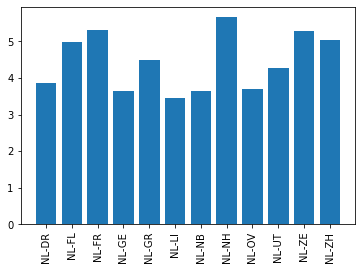

In [11]:
#Plotting means of windspeeds for different regions
means = [reg_dict[i]['WindSpeed']['mean'] for i in reg_dict.keys()]

plt.xticks(rotation=90)
plt.bar(reg_dict.keys(),means)

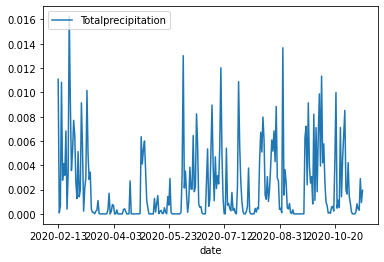

In [12]:
weather_by_day_nl = nl_weather_df.groupby(by = "date").mean()

weather_by_day_nl.loc[:, "Totalprecipitation"].plot.line().legend(loc = "upper left")

In [13]:
nl_map = folium.Map(location = [52.3,5.5], zoom_start = 7.4)
folium.GeoJson('../Data/Raw/shapefiles/nl.geojson', name = "geojson").add_to(nl_map)
folium.LayerControl().add_to(nl_map)

nl_map

In [14]:
final_df.columns = ['population', 'cases']

In [15]:
df = final_df.reset_index()
df.columns = ["region",'population', 'cases']
df

,region,population,cases
0,NL-DR,493657.0,21039.0
1,NL-FL,422979.0,25315.0
2,NL-FR,649944.0,25271.0
3,NL-GE,2086142.0,119495.0
4,NL-GR,586061.0,23161.0
5,NL-LI,1117164.0,69949.0
6,NL-NB,2563432.0,166862.0
7,NL-NH,2879611.0,180576.0
8,NL-OV,1162500.0,74359.0
9,NL-UT,1354979.0,84449.0


In [16]:
# Third task, mapping the number of cases in a choropeth map
# We start by initializing the folium map
nl_map = folium.Map(location = [52.3,5.5], zoom_start = 7.4)

# Then we use the Choropleth function, which requires: the path to the geoJSON (the shapes),
# a name for the layer, the dataframe containing the data, the columns we want to focus on,
# the attribute from the geoJSON which we use to map the data with the corresponding geometry
# in our case this is the iso code. Finally, we specify the color map, and the opacity (so that
# we can still see the map beneath), and a title.
folium.Choropleth(
    geo_data = '../Data/Raw/shapefiles/nl.geojson',
    name = "cases",
    data = df,
    columns = ['region', 'cases'],
    key_on = "properties.iso_3166_2",
    fill_color = "OrRd",
    fill_opacity = 0.7,
    line_opacity = 0.2,
    legend_name = "Number of Cases",
).add_to(nl_map)

nl_map

In [17]:
#heatmap of population distribution across different regions in the Netherlands
nl_map = folium.Map(location = [52.3,5.5], zoom_start = 7.4)

folium.Choropleth(
    geo_data = '../Data/Raw/shapefiles/nl.geojson',
    name = "cases",
    data = df,
    columns = ['region', 'population'],
    key_on = "properties.iso_3166_2",
    fill_color = "YlGn",
    fill_opacity = 0.7,
    line_opacity = 0.2,
    legend_name = "population",
).add_to(nl_map)

nl_map

In [18]:
# Fifth task, we create a new column in our data frame with the cases per capita
df["cases_pc"] = df["cases"] / df["population"]*100

# And we plot it just like we did before
nl_map = folium.Map(location = [52.3,5.5], zoom_start = 7.4)
folium.Choropleth(
    geo_data = '../Data/Raw/shapefiles/nl.geojson',
    name = "cases",
    data = df,
    columns = ['region', 'cases_pc'],
    key_on = "properties.iso_3166_2",
    fill_color = "OrRd",
    fill_opacity = 0.7,
    line_opacity = 0.2,
    legend_name = "number of cases %",
).add_to(nl_map)

nl_map

In [19]:
with open('../data/Raw/metadata/nl_metadata.json') as f:
    metadata = json.load(f)
nl_weather = weather['iso3166-2'].str[:2] == 'NL'
nl_weather_df = weather[nl_weather]
nl_weather_df
#missing data?
#print(nl_weather_df.isna().any().any())
nl_weather_df
reg_dict = {}
names = {}
for i in metadata['country_metadata']:
    reg_dict[int(i['covid_region_code'])] = [i['population']]
    names[int(i['covid_region_code'])] = i['iso3166-2_code']
    

reg_names = set(nl_covid['region_code'])
mask1 = nl_covid['confirmed_addition'].dropna()
mask_idk = nl_covid['confirmed_addition'].notnull()

#print(4344-sum(mask_idk))
for i in list(reg_names):
    mask = (nl_covid['region_code'] == i) & (nl_covid['confirmed_addition'].notnull())
    mask_covid=nl_covid[mask]
    reg_dict[i].append(sum(mask_covid['confirmed_addition']))
df1 = pd.DataFrame.from_dict(reg_dict)
df1 = df1.transpose()
final_df = df1.rename(names)

In [20]:
mask = nl_covid['confirmed_addition'].notnull()
nl_covid_clean = nl_covid[mask]
nl_covid_clean = nl_covid_clean.drop(['deceased_addition','hospitalized_addition','deceased_cumulative','confirmed_cumulative','hospitalized_cumulative'], axis=1)
nl_covid_clean

,date,region_name,region_code,confirmed_addition
12,2020-02-28,Drenthe,22,0.0
13,2020-02-28,Flevoland,24,0.0
14,2020-02-28,Friesland,21,0.0
15,2020-02-28,Gelderland,25,0.0
16,2020-02-28,Groningen,20,0.0
...,...,...,...,...
4339,2021-02-22,Noord-Holland,27,821.0
4340,2021-02-22,Overijssel,23,197.0
4341,2021-02-22,Utrecht,26,291.0
4342,2021-02-22,Zeeland,29,77.0


In [21]:
region_codes = set(nl_covid_clean['region_code'])

nl_covid_clean['region_code'].replace(list(names.keys()), list(names.values()), inplace=True)
nl_covid_clean

,date,region_name,region_code,confirmed_addition
12,2020-02-28,Drenthe,NL-DR,0.0
13,2020-02-28,Flevoland,NL-FL,0.0
14,2020-02-28,Friesland,NL-FR,0.0
15,2020-02-28,Gelderland,NL-GE,0.0
16,2020-02-28,Groningen,NL-GR,0.0
...,...,...,...,...
4339,2021-02-22,Noord-Holland,NL-NH,821.0
4340,2021-02-22,Overijssel,NL-OV,197.0
4341,2021-02-22,Utrecht,NL-UT,291.0
4342,2021-02-22,Zeeland,NL-ZE,77.0


In [22]:
weather_corona = nl_covid_clean.merge(nl_weather_df, left_on=['date','region_code'],right_on=['date','iso3166-2'])
weather_corona.drop(['region_code'],axis=1)

print(nl_covid_clean.shape[0] - weather_corona.shape[0])
print(nl_weather_df.shape[0] - weather_corona.shape[0])
weather_corona

1200
180


,date,region_name,region_code,confirmed_addition,iso3166-2,RelativeHumiditySurface,SolarRadiation,Surfacepressure,TemperatureAboveGround,Totalprecipitation,UVIndex,WindSpeed
0,2020-02-28,Drenthe,NL-DR,0.0,NL-DR,85.273843,2.928512e+06,2.418883e+06,276.640094,0.006936,5.311518,5.604625
1,2020-02-28,Flevoland,NL-FL,0.0,NL-FL,84.473753,1.768177e+06,2.419984e+06,277.652467,0.006982,4.339130,7.142621
2,2020-02-28,Friesland,NL-FR,0.0,NL-FR,83.733823,2.235102e+06,2.418199e+06,277.660126,0.009203,4.835275,7.593261
3,2020-02-28,Gelderland,NL-GE,0.0,NL-GE,85.451835,2.148558e+06,2.419307e+06,276.989081,0.005471,5.283174,5.430404
4,2020-02-28,Groningen,NL-GR,0.0,NL-GR,83.629892,3.309977e+06,2.419139e+06,277.065390,0.008450,5.784530,6.361245
...,...,...,...,...,...,...,...,...,...,...,...,...
3127,2020-11-14,Noord-Holland,NL-NH,890.0,NL-NH,90.139789,3.315327e+05,2.428772e+06,284.412821,0.002788,0.022989,5.937843
3128,2020-11-14,Overijssel,NL-OV,357.0,NL-OV,90.624991,8.355392e+05,2.428846e+06,284.984318,0.001212,0.434870,3.534711
3129,2020-11-14,Utrecht,NL-UT,427.0,NL-UT,89.424252,9.894519e+05,2.429694e+06,285.008331,0.002306,0.135371,4.576365
3130,2020-11-14,Zeeland,NL-ZE,80.0,NL-ZE,87.590779,1.583508e+06,2.429062e+06,285.820956,0.002250,2.522796,6.111993


In [23]:
#Testing correlations for numerical variables in combined weather and covid dataframe
num_columns
withoutzeros = weather_corona["confirmed_addition"].clip(lower=1)
sig_thresh = 0.001 / len(num_columns)*3

for var in num_columns:
    corr,p = pearsonr(weather_corona['confirmed_addition'],weather_corona[var])
    corr2,p2 = spearmanr(weather_corona['confirmed_addition'],weather_corona[var])
    corr3,p3 = pearsonr(np.log(withoutzeros),weather_corona[var])
    print('------------ '+var+' --------------')
    print("-----Pearson------")
    print("Correlation",corr)
    print("P value",p,p<sig_thresh)
    print("-----Spearman------")
    print("Correlation", corr2)
    print("P value", p2,p<sig_thresh)
    print("------LOG-------")
    print("Correlation", corr3)
    print("P value", p3,p<sig_thresh)
    print('\n')

------------ RelativeHumiditySurface --------------
-----Pearson------
Correlation 0.25914485045897523
P value 3.088635268628318e-49 True
-----Spearman------
Correlation 0.17119846530118615
P value 4.9886821071058895e-22 True
------LOG-------
Correlation 0.14730970306380725
P value 1.170904138485524e-16 True


------------ SolarRadiation --------------
-----Pearson------
Correlation -0.3031720996839442
P value 1.3813892518461925e-67 True
-----Spearman------
Correlation -0.24919847742881215
P value 1.515594304489898e-45 True
------LOG-------
Correlation -0.2593124095327117
P value 2.6680281188457745e-49 True


------------ Surfacepressure --------------
-----Pearson------
Correlation -0.04955965853428121
P value 0.005534310881026885 False
-----Spearman------
Correlation 0.027537562453286663
P value 0.12336627487089394 False
------LOG-------
Correlation 0.010111651853898816
P value 0.5716114514402791 False


------------ TemperatureAboveGround --------------
-----Pearson------
Correlatio

In [24]:
weather_corona = sm.add_constant(weather_corona)
num_columns.append('const')

In [25]:

est = sm.OLS(weather_corona['confirmed_addition'],weather_corona[num_columns], hasconst = True).fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:     confirmed_addition   R-squared:                       0.183
Model:                            OLS   Adj. R-squared:                  0.181
Method:                 Least Squares   F-statistic:                     100.1
Date:                Mon, 15 Mar 2021   Prob (F-statistic):          1.99e-132
Time:                        14:59:29   Log-Likelihood:                -22448.
No. Observations:                3132   AIC:                         4.491e+04
Df Residuals:                    3124   BIC:                         4.496e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
RelativeHumiditySurface   

In [26]:
#For log
est = sm.OLS(np.log(weather_corona['confirmed_addition'].clip(lower=1)),weather_corona[num_columns], hasconst = True).fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:     confirmed_addition   R-squared:                       0.301
Model:                            OLS   Adj. R-squared:                  0.299
Method:                 Least Squares   F-statistic:                     192.1
Date:                Mon, 15 Mar 2021   Prob (F-statistic):          1.91e-237
Time:                        14:59:29   Log-Likelihood:                -6188.6
No. Observations:                3132   AIC:                         1.239e+04
Df Residuals:                    3124   BIC:                         1.244e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
RelativeHumiditySurface   

In [27]:
#dataframe containing only cases during spring lockdown
lockdown = (nl_covid['date'] > '2020-03-15') & (nl_covid['date'] < '2020-04-28')

yes = nl_covid[lockdown]

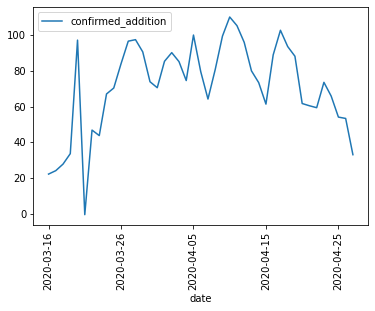

In [28]:
nl_covid_by_day =  yes.groupby(by='date').mean()

nl_covid_by_day.loc[:,'confirmed_addition'].plot.line(rot=90).legend(loc='upper left')

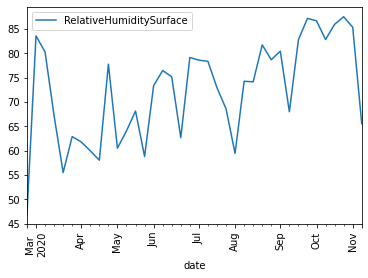

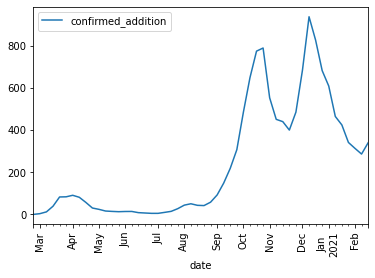

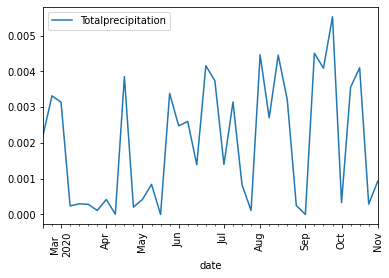

In [29]:
#plotting covid and weather data by weeks, to better visualize data
plt.figure(0)
weather_corona['date'] = pd.to_datetime(weather_corona['date']) - pd.to_timedelta(7, unit='d')
df = weather_corona.groupby(['region_name', pd.Grouper(key='date', freq='W-MON')])['RelativeHumiditySurface'].sum().reset_index().sort_values('date')
df['RelativeHumiditySurface'] = df['RelativeHumiditySurface']/7
nl_covid_by_day =  df.groupby(by='date').mean()
nl_covid_by_day.loc[:,'RelativeHumiditySurface'].plot.line(rot=90).legend(loc='upper left')
plt.figure(1)
nl_covid['date'] = pd.to_datetime(nl_covid['date']) - pd.to_timedelta(7, unit='d')
df = nl_covid.groupby(['region_name', pd.Grouper(key='date', freq='W-MON')])['confirmed_addition'].sum().reset_index().sort_values('date')
df['confirmed_addition'] = df['confirmed_addition']/7
nl_covid_by_day =  df.groupby(by='date').mean()
nl_covid_by_day.loc[:,'confirmed_addition'].plot.line(rot=90).legend(loc='upper left')
plt.figure(2)
weather_corona['date'] = pd.to_datetime(weather_corona['date']) - pd.to_timedelta(7, unit='d')
df = weather_corona.groupby(['region_name', pd.Grouper(key='date', freq='W-MON')])['Totalprecipitation'].sum().reset_index().sort_values('date')
df['Totalprecipitation'] = df['Totalprecipitation']/7
nl_covid_by_day =  df.groupby(by='date').mean()
nl_covid_by_day.loc[:,'Totalprecipitation'].plot.line(rot=90).legend(loc='upper left')

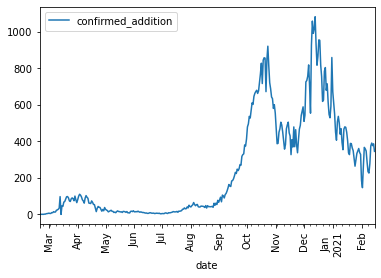

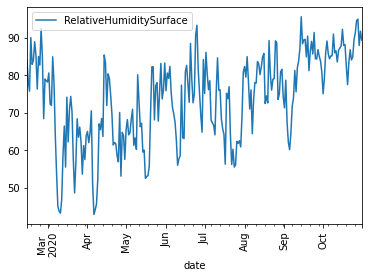

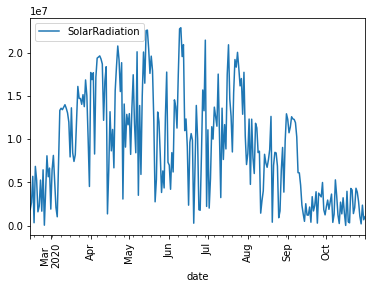

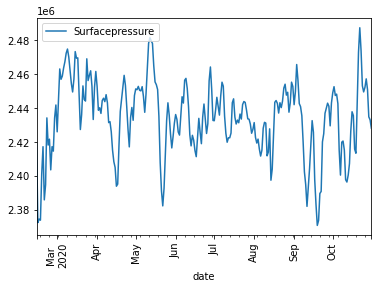

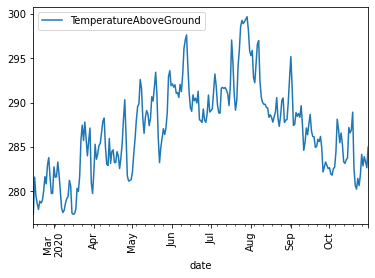

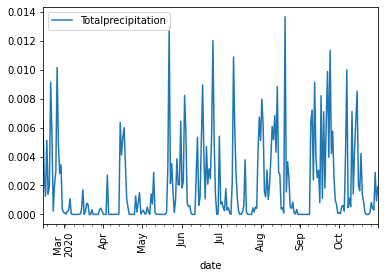

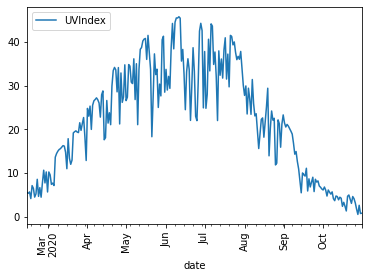

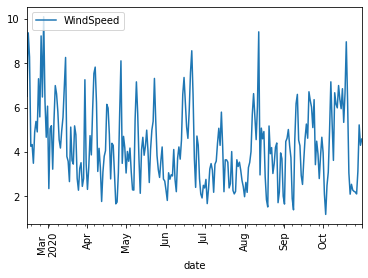

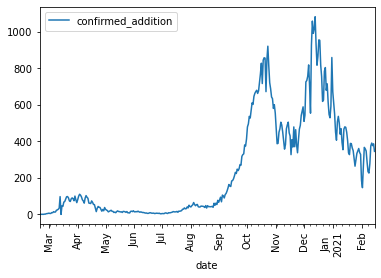

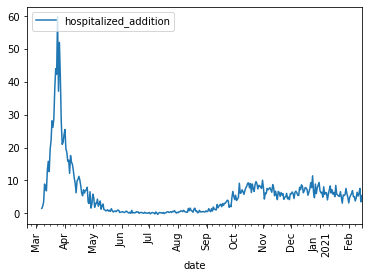

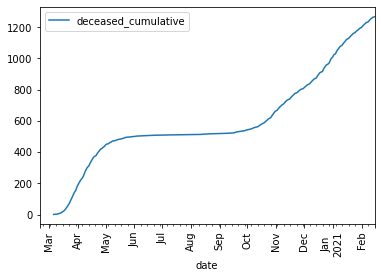

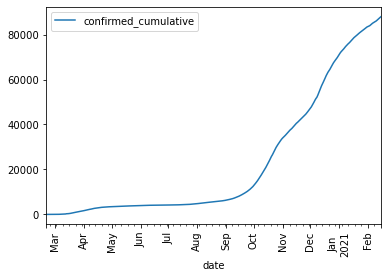

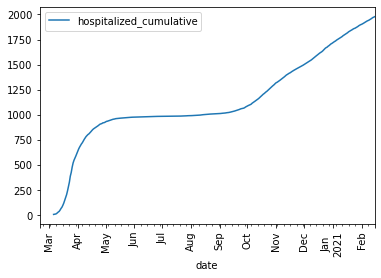

In [30]:
#visualizing covid and weather data using lineplots 
plt.figure(1)
nl_covid_by_day =  nl_covid.groupby(by='date').mean()

nl_covid_by_day.loc[:,'confirmed_addition'].plot.line(rot=90).legend(loc='upper left')

#nl_covid_by_day.iloc[:,'confirmed_addition'].plot.line()

plt.figure(2)
nl_covid_by_day =  weather_corona.groupby(by='date').mean()
nl_covid_by_day.loc[:,'RelativeHumiditySurface'].plot.line(rot=90).legend(loc='upper left')

some_list = []
for i in weather_corona:
    some_list.append(i)
counter = 3
for i in some_list[7:]:
    plt.figure(counter)
    nl_covid_by_day =  weather_corona.groupby(by='date').mean()
    nl_covid_by_day.loc[:,i].plot.line(rot=90).legend(loc='upper left')
    counter += 1
    
some_list = []
for i in nl_covid:
    some_list.append(i)
for i in some_list[4:]:
    plt.figure(counter)
    nl_covid_by_day =  nl_covid.groupby(by='date').mean()
    nl_covid_by_day.loc[:,i].plot.line(rot=90).legend(loc='upper left')
    counter += 1

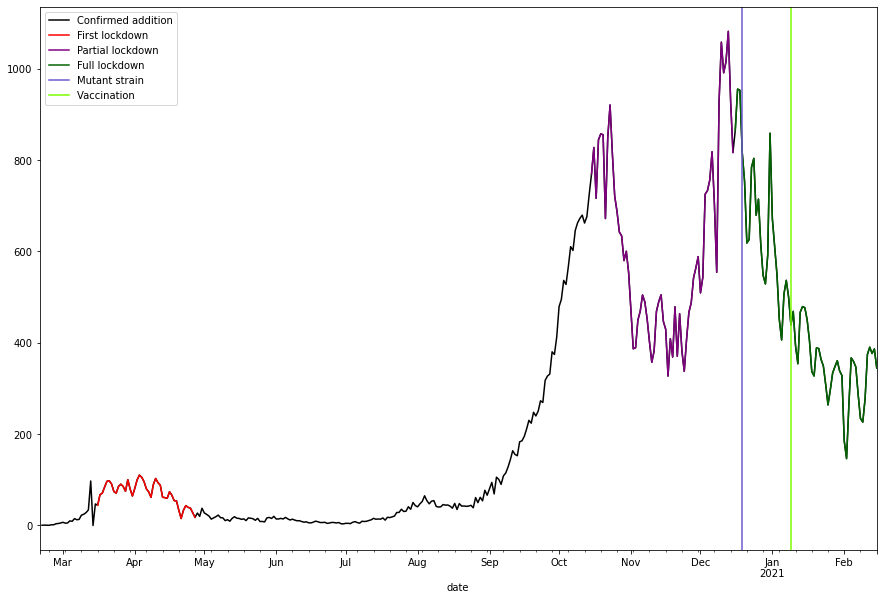

In [31]:
first_lockdown = (nl_covid['date'] > '2020-03-15') & (nl_covid['date'] < '2020-04-28')
october_partial_lockdown = (nl_covid['date'] > '2020-10-14') & (nl_covid['date'] <= '2020-12-15')
hard_december_lockdown = (nl_covid['date'] > '2020-12-15') & (nl_covid['date'] < '2021-03-15')
plt.figure(figsize=(15,10))
nl_covid_by_day =  nl_covid.groupby(by='date').mean()
first_lockdown_by_day = nl_covid[first_lockdown].groupby('date').mean()
october_partial_lockdown_by_day  = nl_covid[october_partial_lockdown].groupby('date').mean()
hard_december_lockdown_by_day  = nl_covid[hard_december_lockdown].groupby('date').mean()

ax = nl_covid_by_day.loc[:,'confirmed_addition'].plot.line(color='k',rot=90,label='Confirmed addition') #covid addition daily
first_lockdown_by_day.loc[:,'confirmed_addition'].plot.line(color ='r',label='First lockdown',ax=ax) #first lockdown
october_partial_lockdown_by_day.loc[:,'confirmed_addition'].plot.line(color ='purple',label='Partial lockdown',ax=ax) #october partial lockdown
hard_december_lockdown_by_day.loc[:,'confirmed_addition'].plot.line(color ='darkgreen',label='Full lockdown',ax=ax) #october partial lockdown
plt.axvline('2020-12-19',label='Mutant strain ',color='slateblue')
plt.axvline('2021-01-09',label='Vaccination ',color='lawngreen')
plt.legend()
plt.show()

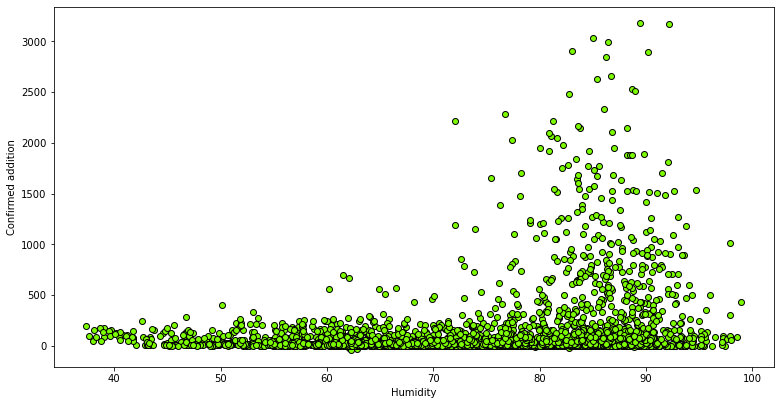

In [32]:
fig = plt.figure(figsize=(10,5))
axes = fig.add_axes([0,0,1,1])
axes.set_xlabel('Humidity')
axes.set_ylabel('Confirmed addition')
m,b,c,d = np.polyfit(weather_corona['RelativeHumiditySurface'], weather_corona['confirmed_addition'],3)
#plt.plot(weather_corona['RelativeHumiditySurface'], m*(weather_corona['RelativeHumiditySurface'])**3+b*weather_corona['RelativeHumiditySurface']**2 + c*weather_corona['RelativeHumiditySurface']  + d)
axes.scatter(weather_corona['RelativeHumiditySurface'], weather_corona['confirmed_addition'],edgecolor='k',color='lawngreen')

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


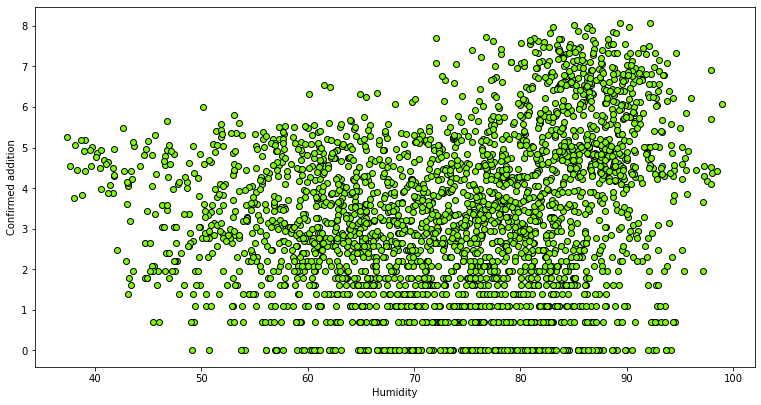

In [33]:
fig = plt.figure(figsize=(10,5))
axes = fig.add_axes([0,0,1,1])
axes.set_xlabel('Humidity')
axes.set_ylabel('Confirmed addition')
#m,b,c,d = np.polyfit(np.log(weather_corona['RelativeHumiditySurface']), np.log(weather_corona['confirmed_addition']),3)
#plt.plot(weather_corona['RelativeHumiditySurface'], m*(weather_corona['RelativeHumiditySurface'])**3+b*weather_corona['RelativeHumiditySurface']**2 + c*weather_corona['RelativeHumiditySurface']  + d)
axes.scatter(weather_corona['RelativeHumiditySurface'], np.log(weather_corona['confirmed_addition']),edgecolor='k',color='lawngreen')

In [34]:
weather_corona

,const,date,region_name,region_code,confirmed_addition,iso3166-2,RelativeHumiditySurface,SolarRadiation,Surfacepressure,TemperatureAboveGround,Totalprecipitation,UVIndex,WindSpeed
0,1.0,2020-02-14,Drenthe,NL-DR,0.0,NL-DR,85.273843,2.928512e+06,2.418883e+06,276.640094,0.006936,5.311518,5.604625
1,1.0,2020-02-14,Flevoland,NL-FL,0.0,NL-FL,84.473753,1.768177e+06,2.419984e+06,277.652467,0.006982,4.339130,7.142621
2,1.0,2020-02-14,Friesland,NL-FR,0.0,NL-FR,83.733823,2.235102e+06,2.418199e+06,277.660126,0.009203,4.835275,7.593261
3,1.0,2020-02-14,Gelderland,NL-GE,0.0,NL-GE,85.451835,2.148558e+06,2.419307e+06,276.989081,0.005471,5.283174,5.430404
4,1.0,2020-02-14,Groningen,NL-GR,0.0,NL-GR,83.629892,3.309977e+06,2.419139e+06,277.065390,0.008450,5.784530,6.361245
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3127,1.0,2020-10-31,Noord-Holland,NL-NH,890.0,NL-NH,90.139789,3.315327e+05,2.428772e+06,284.412821,0.002788,0.022989,5.937843
3128,1.0,2020-10-31,Overijssel,NL-OV,357.0,NL-OV,90.624991,8.355392e+05,2.428846e+06,284.984318,0.001212,0.434870,3.534711
3129,1.0,2020-10-31,Utrecht,NL-UT,427.0,NL-UT,89.424252,9.894519e+05,2.429694e+06,285.008331,0.002306,0.135371,4.576365
3130,1.0,2020-10-31,Zeeland,NL-ZE,80.0,NL-ZE,87.590779,1.583508e+06,2.429062e+06,285.820956,0.002250,2.522796,6.111993


In [35]:
# Fifth task, we create a new column in our data frame with the cases per capita
# df["cases_pc"] = df["cases"] / df["population"]*100

# # And we plot it just like we did before
# nl_map = folium.Map(location = [52.3,5.5], zoom_start = 7.4)
# folium.Choropleth(
#     geo_data = '../Data/Raw/shapefiles/nl.geojson',
#     name = "cases",
#     data = df,
#     columns = ['region', 'cases_pc'],
#     key_on = "properties.iso_3166_2",
#     fill_color = "OrRd",
#     fill_opacity = 0.7,
#     line_opacity = 0.2,
#     legend_name = "number of cases %",
# ).add_to(nl_map)

#nl_map

region_humidity = {}

reg_names = set(weather_corona['region_code'])

for name in list(reg_names):
    mask = weather_corona['region_code'] == name
    region_humidity[name] = [sum(weather_corona[mask]['RelativeHumiditySurface'])/len(weather_corona[mask])]
    #print(sum(weather_corona[mask]['RelativeHumiditySurface'])/len(weather_corona[mask]))



region_humidity_df = pd.DataFrame.from_dict(region_humidity)
region_humidity_df = region_humidity_df.transpose().reset_index()
region_humidity_df.rename(columns = {'index':'region',0:'AVG humidity'}, inplace = True)
region_humidity_df




,region,AVG humidity
0,NL-GE,72.303198
1,NL-DR,75.431712
2,NL-ZE,73.749654
3,NL-NB,70.710197
4,NL-FR,77.318697
5,NL-GR,76.173545
6,NL-UT,72.866068
7,NL-ZH,73.610874
8,NL-FL,75.233941
9,NL-NH,75.304531


In [36]:
#Average humidity by region
nl_map = folium.Map(location = [52.3,5.5], zoom_start = 7.4)
folium.Choropleth(
    geo_data = '../Data/Raw/shapefiles/nl.geojson',
    name = "AVG humidity",
    data = region_humidity_df,
    columns = ['region', 'AVG humidity'],
    key_on = "properties.iso_3166_2",
    fill_color = "OrRd",
    fill_opacity = 0.7,
    line_opacity = 0.2,
    legend_name = "average humidity",
).add_to(nl_map)

nl_map


In [37]:
region_UVindex = {}

reg_names = set(weather_corona['region_code'])

for name in list(reg_names):
    mask = weather_corona['region_code'] == name
    region_UVindex[name] = [sum(weather_corona[mask]['UVIndex'])/len(weather_corona[mask])]
    #print(sum(weather_corona[mask]['RelativeHumiditySurface'])/len(weather_corona[mask]))



region_humidity_df = pd.DataFrame.from_dict(region_UVindex)
region_humidity_df = region_humidity_df.transpose().reset_index()
region_humidity_df.rename(columns = {'index':'region',0:'AVG UV'}, inplace = True)
region_humidity_df

,region,AVG UV
0,NL-GE,20.942031
1,NL-DR,20.142515
2,NL-ZE,24.887701
3,NL-NB,22.374344
4,NL-FR,20.681049
5,NL-GR,21.076840
6,NL-UT,22.143486
7,NL-ZH,23.979555
8,NL-FL,20.460625
9,NL-NH,22.264236


In [38]:
#Average humidity by region
nl_map = folium.Map(location = [52.3,5.5], zoom_start = 7.4)
folium.Choropleth(
    geo_data = '../Data/Raw/shapefiles/nl.geojson',
    name = "AVG UV",
    data = region_humidity_df,
    columns = ['region', 'AVG UV'],
    key_on = "properties.iso_3166_2",
    fill_color = "OrRd",
    fill_opacity = 0.7,
    line_opacity = 0.2,
    legend_name = "average UV",
).add_to(nl_map)

nl_map


In [39]:
Lockdown_True = (weather_corona['date'] > '2020-03-15') & (weather_corona['date'] < '2020-04-28') | (weather_corona['date'] > '2020-10-14') & (weather_corona['date'] <= '2020-12-15') | (weather_corona['date'] > '2020-12-15') & (weather_corona['date'] < '2021-03-15')
weather_corona['Lockdown'] = list(Lockdown_True)
weather_corona['Lockdown'].replace([True,False],[1,0],inplace = True)

In [40]:
num_columns.append('holiday')
num_columns.append('Lockdown')
num_columns.append('weekend')
num_columns.append('no_school')

In [41]:
weather_corona['weekend'] = 0
weather_corona['weekend'] = (pd.to_datetime(weather_corona['date'],format = '%Y-%m-%d').dt.weekday >= 5).astype(int)
weather_corona['holiday'] = 0

no_school = (weather_corona['date'] > '2020-03-12') & (weather_corona['date']<'2020-06-08')
weather_corona['no_school'] = list(no_school)
weather_corona['no_school'].replace([True,False],[1,0],inplace=True)
weather_corona.loc[weather_corona['date'] == '2020-01-01','holiday'] = 1
weather_corona.loc[weather_corona['date'] == '2020-04-10','holiday'] = 1
weather_corona.loc[weather_corona['date'] == '2020-04-12','holiday'] = 1
weather_corona.loc[weather_corona['date'] == '2020-04-13','holiday'] = 1
weather_corona.loc[weather_corona['date'] == '2020-04-27','holiday'] = 1
weather_corona.loc[weather_corona['date'] == '2020-05-05','holiday'] = 1
weather_corona.loc[weather_corona['date'] == '2020-05-21','holiday'] = 1
weather_corona.loc[weather_corona['date'] == '2020-05-31','holiday'] = 1
weather_corona.loc[weather_corona['date'] == '2020-06-01','holiday'] = 1
weather_corona.loc[weather_corona['date'] == '2020-12-25','holiday'] = 1
weather_corona.loc[weather_corona['date'] == '2020-12-26','holiday'] = 1
weather_corona

,const,date,region_name,region_code,confirmed_addition,iso3166-2,RelativeHumiditySurface,SolarRadiation,Surfacepressure,TemperatureAboveGround,Totalprecipitation,UVIndex,WindSpeed,Lockdown,weekend,holiday,no_school
0,1.0,2020-02-14,Drenthe,NL-DR,0.0,NL-DR,85.273843,2.928512e+06,2.418883e+06,276.640094,0.006936,5.311518,5.604625,0,0,0,0
1,1.0,2020-02-14,Flevoland,NL-FL,0.0,NL-FL,84.473753,1.768177e+06,2.419984e+06,277.652467,0.006982,4.339130,7.142621,0,0,0,0
2,1.0,2020-02-14,Friesland,NL-FR,0.0,NL-FR,83.733823,2.235102e+06,2.418199e+06,277.660126,0.009203,4.835275,7.593261,0,0,0,0
3,1.0,2020-02-14,Gelderland,NL-GE,0.0,NL-GE,85.451835,2.148558e+06,2.419307e+06,276.989081,0.005471,5.283174,5.430404,0,0,0,0
4,1.0,2020-02-14,Groningen,NL-GR,0.0,NL-GR,83.629892,3.309977e+06,2.419139e+06,277.065390,0.008450,5.784530,6.361245,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3127,1.0,2020-10-31,Noord-Holland,NL-NH,890.0,NL-NH,90.139789,3.315327e+05,2.428772e+06,284.412821,0.002788,0.022989,5.937843,1,1,0,0
3128,1.0,2020-10-31,Overijssel,NL-OV,357.0,NL-OV,90.624991,8.355392e+05,2.428846e+06,284.984318,0.001212,0.434870,3.534711,1,1,0,0
3129,1.0,2020-10-31,Utrecht,NL-UT,427.0,NL-UT,89.424252,9.894519e+05,2.429694e+06,285.008331,0.002306,0.135371,4.576365,1,1,0,0
3130,1.0,2020-10-31,Zeeland,NL-ZE,80.0,NL-ZE,87.590779,1.583508e+06,2.429062e+06,285.820956,0.002250,2.522796,6.111993,1,1,0,0


In [42]:
    corr,p = pearsonr(weather_corona['confirmed_addition'],weather_corona['Lockdown'])
    corr2,p2 = spearmanr(weather_corona['confirmed_addition'],weather_corona['Lockdown'])
    corr3,p3 = pearsonr(np.log(withoutzeros),weather_corona['Lockdown'])
    print('------------ '+'Lockdown?'+' --------------')
    print("-----Pearson------")
    print("Correlation",corr)
    print("P value",p,p<sig_thresh)
    print("-----Spearman------")
    print("Correlation", corr2)
    print("P value", p2,p<sig_thresh)
    print("------LOG-------")
    print("Correlation", corr3)
    print("P value", p3,p<sig_thresh)
    print('\n')

------------ Lockdown? --------------
-----Pearson------
Correlation 0.11500185137775881
P value 1.0832502431394793e-10 True
-----Spearman------
Correlation 0.26448996288393734
P value 2.745643441091437e-51 True
------LOG-------
Correlation 0.2576653481077483
P value 1.119710824913422e-48 True




In [43]:
df = final_df.reset_index()
df.columns = ["region",'population', 'cases']
weather_corona = weather_corona.merge(df, left_on=['region_code'],right_on=['region'])
weather_corona.drop('region',axis=1)

,const,date,region_name,region_code,confirmed_addition,iso3166-2,RelativeHumiditySurface,SolarRadiation,Surfacepressure,TemperatureAboveGround,Totalprecipitation,UVIndex,WindSpeed,Lockdown,weekend,holiday,no_school,population,cases
0,1.0,2020-02-14,Drenthe,NL-DR,0.0,NL-DR,85.273843,2.928512e+06,2.418883e+06,276.640094,0.006936,5.311518,5.604625,0,0,0,0,493657.0,21039.0
1,1.0,2020-02-15,Drenthe,NL-DR,0.0,NL-DR,80.257003,2.841131e+06,2.371918e+06,281.328435,0.002324,4.934555,8.246477,0,1,0,0,493657.0,21039.0
2,1.0,2020-02-16,Drenthe,NL-DR,1.0,NL-DR,75.513798,4.759941e+06,2.373856e+06,278.924656,0.001929,5.123037,7.386202,0,1,0,0,493657.0,21039.0
3,1.0,2020-02-17,Drenthe,NL-DR,0.0,NL-DR,91.237664,5.649723e+05,2.374793e+06,278.098476,0.006125,2.363874,3.540609,0,0,0,0,493657.0,21039.0
4,1.0,2020-02-18,Drenthe,NL-DR,1.0,NL-DR,85.908015,6.732560e+06,2.400501e+06,277.428121,0.001744,6.442408,3.668597,0,0,0,0,493657.0,21039.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3127,1.0,2020-10-27,Zuid-Holland,NL-ZH,1182.0,NL-ZH,93.763647,1.290511e+06,2.459498e+06,285.417655,0.000869,3.383948,1.955034,1,0,0,0,3708585.0,250759.0
3128,1.0,2020-10-28,Zuid-Holland,NL-ZH,1533.0,NL-ZH,94.676392,1.449670e+05,2.452663e+06,284.415953,0.000165,0.993492,3.962166,1,0,0,0,3708585.0,250759.0
3129,1.0,2020-10-29,Zuid-Holland,NL-ZH,1526.0,NL-ZH,86.833884,2.698975e+06,2.437308e+06,283.674702,0.002265,2.277657,6.136334,1,0,0,0,3708585.0,250759.0
3130,1.0,2020-10-30,Zuid-Holland,NL-ZH,1487.0,NL-ZH,91.831301,3.569254e+05,2.435425e+06,283.096617,0.000671,0.008677,4.770454,1,0,0,0,3708585.0,250759.0


In [44]:
weather_corona['cases_per_c'] = weather_corona['confirmed_addition']/weather_corona['population']

In [45]:
est = sm.OLS(weather_corona['cases_per_c'],weather_corona[num_columns], hasconst = True).fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:            cases_per_c   R-squared:                       0.384
Model:                            OLS   Adj. R-squared:                  0.382
Method:                 Least Squares   F-statistic:                     177.0
Date:                Mon, 15 Mar 2021   Prob (F-statistic):          1.80e-318
Time:                        14:59:40   Log-Likelihood:                 24077.
No. Observations:                3132   AIC:                        -4.813e+04
Df Residuals:                    3120   BIC:                        -4.806e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
RelativeHumiditySurface  1

In [46]:
#testing external data, maybe done b4 idk lol
est = sm.OLS(tests['Tested_positive'],tests[['Tested_with_result','weekend']], hasconst = True).fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:        Tested_positive   R-squared:                       0.734
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                 1.969e+04
Date:                Mon, 15 Mar 2021   Prob (F-statistic):               0.00
Time:                        14:59:40   Log-Likelihood:                -40972.
No. Observations:                7125   AIC:                         8.195e+04
Df Residuals:                    7123   BIC:                         8.196e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Tested_with_result     0.1132      0

In [47]:
set(tests['weekend'])

{0, 1}